In [41]:
import scipy
import numpy as np
import data_import
import matplotlib.pyplot as plt

In [29]:

def get_policy(Q, x, b, policy):
    """
    updates policy to the next policy,
    returns error
    """
    err2 = 0
    y = np.dot(Q, x) + b
    for i in range(len(x)):
        choice = 0.0
        if y[i] < x[i]:
            choice = 1
        err2 += min(x[i], y[i]) ** 2    # x should be > 0, while y should be as close to 0 as possible

        policy[i,i] = choice
    flat_policy = [i for i in range(policy.shape[0]) if policy[i,i] == 1]
    return err2 ** 0.5

def update_value(policy, Q, b, use_cg = True):
    """
    returns the next x given the policy
    """
    I = np.eye(len(b))
    A = np.dot(
            np.dot(
                policy,
                Q
            ),
            policy
        ) + I - policy
    rhs = -np.dot(policy, b) 
    lst_sqr_soln = np.linalg.lstsq(A , rhs)[0]
    cg_soln = scipy.sparse.linalg.cg(A , rhs , tol=1e-12)[0]
    # print(
    #     "cg soln err:",
    #     np.linalg.norm(
    #         np.dot(A, cg_soln) - rhs
    #     )
    # )
    if use_cg:
        return cg_soln
    else:
        return lst_sqr_soln


def flow(Q, N, v0, max_itrs = 100, m_tol = 1e-09, CoR = 1):
    """
    does policy iteration
    returns a bool/vector pair: (converged, x)
    """
    # print("new")
    min_err = 1.0e10
    b = np.dot(N.T, (1 + CoR) * v0)
    # print("b")
    # print(b)
    x = np.zeros(b.shape[0])
    policy = np.zeros((b.shape[0], b.shape[0]))
    error = 0.0

    previous_lambdas = []
    cg_ls_diff = []
    A_det = []
    resid = []

    for n_iter in range(max_itrs):
        # print("n_iter: ", n_iter)
        error = get_policy(Q, x, b, policy)
        min_err = min(min_err, error)
        # print(error)

        if error <= m_tol:
            return (True, x, min_err, -1, cg_ls_diff, A_det, resid)

        x_cg = update_value(policy, Q, b, True)
        x_ls = update_value(policy, Q, b, False)

        cg_ls_diff.append(np.linalg.norm(x_cg - x_ls))

        A = np.dot( np.dot( policy, Q), policy) + np.eye(len(b)) - policy
        rhs = -np.dot(policy, b) 
        A_det.append(np.linalg.det(A))

        resid.append((
            np.linalg.norm(np.dot(A, x_cg) - rhs),
            np.linalg.norm(np.dot(A, x_ls) - rhs)
        ))

        x = x_ls.copy()

        
        if list(x) in previous_lambdas:
            return (False , x, min_err, len(previous_lambdas) - previous_lambdas.index(list(x)), cg_ls_diff, A_det, resid)
        
        previous_lambdas.append(list(x.copy()))
    
    return (False, x, min_err, -1, cg_ls_diff, A_det, resid)  # shouldn't get here


In [10]:
pd_data = data_import.read_files_to_pd_dataframe(
    [f"../outs/grid/itr_{i}.xml.out" for i in range(500)]
)
# pd_data = data_import.read_file_to_pd_dataframe("../simple_example.out")
# pd_data = data_import.read_file_to_pd_dataframe("../K4.out")

In [8]:
np.set_printoptions(linewidth=2000, precision=10)

# ensure that cg solution yields least sqr soln

In [40]:
cg_ls_diff_t = []
A_det_t = []
resid_t = []
min_err_t = []
cycle_size_t = []
for i in range(len(pd_data)):
    Q = pd_data['Q'][i]
    N = pd_data['N'][i]
    v0= pd_data['v0'][i]
    converged, x, min_err, cycle_size, cg_ls_diff, A_det, resid = flow(Q, N, v0)
    cg_ls_diff_t += cg_ls_diff.copy()
    A_det_t += A_det.copy()
    resid_t += resid.copy()
    min_err_t.append(min_err)
    cycle_size_t.append(cycle_size)

/tmp/ipykernel_187884/773912813.py:31: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  lst_sqr_soln = np.linalg.lstsq(A , rhs)[0]


In [33]:
print(len(cg_ls_diff_t))
print(len(A_det_t))
print(len(resid_t))

5318
5318
5318


In [39]:
diff_soln_counter = 0

for i in range(len(A_det_t)):
    # non singular.... ensure that both cg and lst sqrs soln is the same
    if abs(A_det_t[i]) > 1e-06 and abs(cg_ls_diff_t[i]) > 1e-06:
        print("AHHHHH ", i) # this never prints
    
    # singular.... ensure that cg and lst sqrs is different sometimes
    if abs(A_det_t[i]) <= 1e-06 and abs(cg_ls_diff_t[i]) > 1e-06:
        diff_soln_counter += 1

    # does "quality of lambda" change if we are using cg vs ls?
    if abs(resid_t[i][0] - resid_t[i][1]) > 1e-07:
        print("ASKLJDDASLKJSDAJKLJKL", i, abs(resid_t[i][0] - resid_t[i][1]), A_det_t[i], cg_ls_diff_t[i])

print(diff_soln_counter)

ASKLJDDASLKJSDAJKLJKL 1158 0.5199058841262565 -3.0449074646393275e-87 426357.7229872154
ASKLJDDASLKJSDAJKLJKL 4894 2.0766893572145443e-05 1.7655497112900267e-71 268.0459010596703
837


## takeaways:
- cg = least squares when A is singular (expected)
- cg and least squares are sometimes different when A is singular (expected)
    - with probability of difference ~= 16%
- residual norm is different when A singular on very rare occasions (~2/5000 or less than 0.04%)
    - one of the times, difference was very small (O(1e-5))
    - other time difference was fairly large (~0.5)! 
    - both of these times the norm between lst squares soln and cg soln was ~250 and ~400,000 respectively

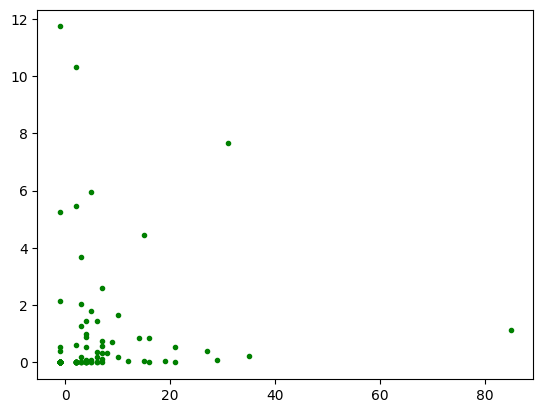

In [43]:
# cycle size vs min err
plt.plot(cycle_size_t, min_err_t, "g.")

In [7]:

pd_data['Q_det']

0     4.173505e-18
1    -4.031944e-36
2     2.034247e-18
3    -1.123775e-46
4    -1.222691e-39
          ...     
95   -1.838282e-28
96   -7.435175e-76
97   -5.778868e-78
98    2.327821e-33
99    2.302561e-40
Name: Q_det, Length: 100, dtype: float64